<a href="https://colab.research.google.com/github/vikram0230/Mustache-Detection/blob/main/Mustache%20Detection%20without%20OpenCV/mustache_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Importing Data** 🌐

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import zipfile
import os
from keras.layers import Dense,Flatten,MaxPool2D,Conv2D,Dropout,GlobalAveragePooling2D
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.models import Model,Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from google.colab import files
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# upload kaggle API key
files.upload()

In [3]:
# Upload haarcascade_frontalface_default
files.upload()

face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [00:49<00:00, 34.6MB/s]
100% 1.33G/1.33G [00:49<00:00, 28.9MB/s]


In [6]:
!mkdir train

In [ ]:
!unzip celeba-dataset.zip -d train

In [8]:
BASE_PATH = '/content/train/img_align_celeba/img_align_celeba/'

In [9]:
attributes = pd.read_csv('/content/train/list_attr_celeba.csv',index_col='image_id')

In [10]:
attributes.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


# **Data Analysis And Validation** 🤓 

In [11]:
# Dataset Correction

attributes.loc['065618.jpg']['Mustache'] = -1
attributes.loc['119681.jpg']['Mustache'] = -1
attributes.loc['133479.jpg']['Male'] = 1
attributes.drop(index='009561.jpg',axis=0,inplace=True)

In [12]:
# Male Count

attributes.Male.value_counts()

-1    118164
 1     84434
Name: Male, dtype: int64

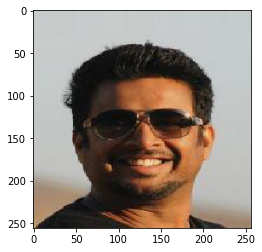

In [13]:
img = load_img(BASE_PATH+'116878.jpg',target_size=(256,256))
plt.imshow(img)

In [14]:
# Male with mustache

male = attributes[attributes.Male == 1]
male_with_mustache = male[male.Mustache == 1]


# Male without mustache

male_without_mustache = male[male.Mustache == -1]
male_without_mustache_duplicate = male_without_mustache[:8415]

In [15]:
male_with_mustache.shape,male_without_mustache_duplicate.shape

((8415, 40), (8415, 40))

In [16]:
def detectedFaces(img):
  image = cv2.imread(BASE_PATH + img.name)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faces = face_classifier.detectMultiScale(gray, 1.05, 5)

  if faces is ():
    return -1
  return 1

In [ ]:
male_with_mustache['DetectedFace'] = male_with_mustache.apply(detectedFaces, axis = 1)
male_without_mustache_duplicate['DetectedFace'] = male_without_mustache_duplicate.apply(detectedFaces, axis = 1)

In [18]:
male_with_mustache.DetectedFace.value_counts()

 1    8033
-1     382
Name: DetectedFace, dtype: int64

In [19]:
male_without_mustache_duplicate.DetectedFace.value_counts()

 1    8062
-1     353
Name: DetectedFace, dtype: int64

In [ ]:
# Remove undetected faces

male_with_mustache.drop(male_with_mustache[male_with_mustache['DetectedFace'] < 0].index, inplace = True) 
male_without_mustache_duplicate.drop(male_without_mustache_duplicate[male_without_mustache_duplicate['DetectedFace'] < 0].index, inplace = True) 

In [21]:
mwm = male_with_mustache.iloc[:8000]
mwom = male_without_mustache_duplicate.iloc[:8000]

In [22]:
mustache_data = pd.DataFrame(mwm)
mustache_data = mustache_data.append(mwom)
mustache_data = mustache_data.Mustache

In [23]:
# Data Shuffling
mustache_data = pd.DataFrame(mustache_data.sample(frac=1))

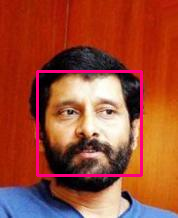

In [24]:
image = cv2.imread(BASE_PATH+'016557.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_classifier.detectMultiScale(gray, 1.01, 5)

if faces is ():
    print("No faces found")

for (x,y,w,h) in faces:
    cv2.rectangle(image, (x,y), (x+w,y+h), (127,0,255), 2)
    cv2_imshow(image)
    cv2.waitKey(0)

In [25]:
mustache_data.head()

,Mustache
image_id,
005030.jpg,-1
081669.jpg,1
017429.jpg,-1
002990.jpg,-1
101705.jpg,1


In [26]:
def detectFace(image,imageName):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_classifier.detectMultiScale(gray, 1.05, 5)

  if faces is ():
      print(imageName)
      return 

  for (x,y,w,h) in faces:
      cv2.rectangle(image, (x,y), (x+w,y+h), (127,0,255), 2)
  return image

In [27]:
def concatHoriz1(img):
  img2 = cv2.imread(BASE_PATH + img.name) 
  img2 = detectFace(img2,img.name)
  global images1
  images1 = np.concatenate((images1, img2), axis=1)

def concatHoriz2(img):
  img2 = cv2.imread(BASE_PATH + img.name) 
  img2 = detectFace(img2,img.name)
  global images2
  images2 = np.concatenate((images2, img2), axis=1)

def concatHoriz3(img):
  img2 = cv2.imread(BASE_PATH + img.name) 
  img2 = detectFace(img2,img.name)
  global images3
  images3 = np.concatenate((images3, img2), axis=1)

In [28]:
global images1,images2,images3

initImage1 = cv2.imread(BASE_PATH + mustache_data.index[0])
images1 = detectFace(initImage1,mustache_data.index[0])
_ = mustache_data[1:15].apply(lambda img: concatHoriz1(img), axis=1)

initImage2 = cv2.imread(BASE_PATH + mustache_data.index[15])
images2 = detectFace(initImage2,mustache_data.index[0])
_ = mustache_data[16:30].apply(lambda img: concatHoriz2(img), axis=1)

initImage3 = cv2.imread(BASE_PATH + mustache_data.index[30])
images3 = detectFace(initImage3,mustache_data.index[0])
_ = mustache_data[31:45].apply(lambda img: concatHoriz3(img), axis=1)

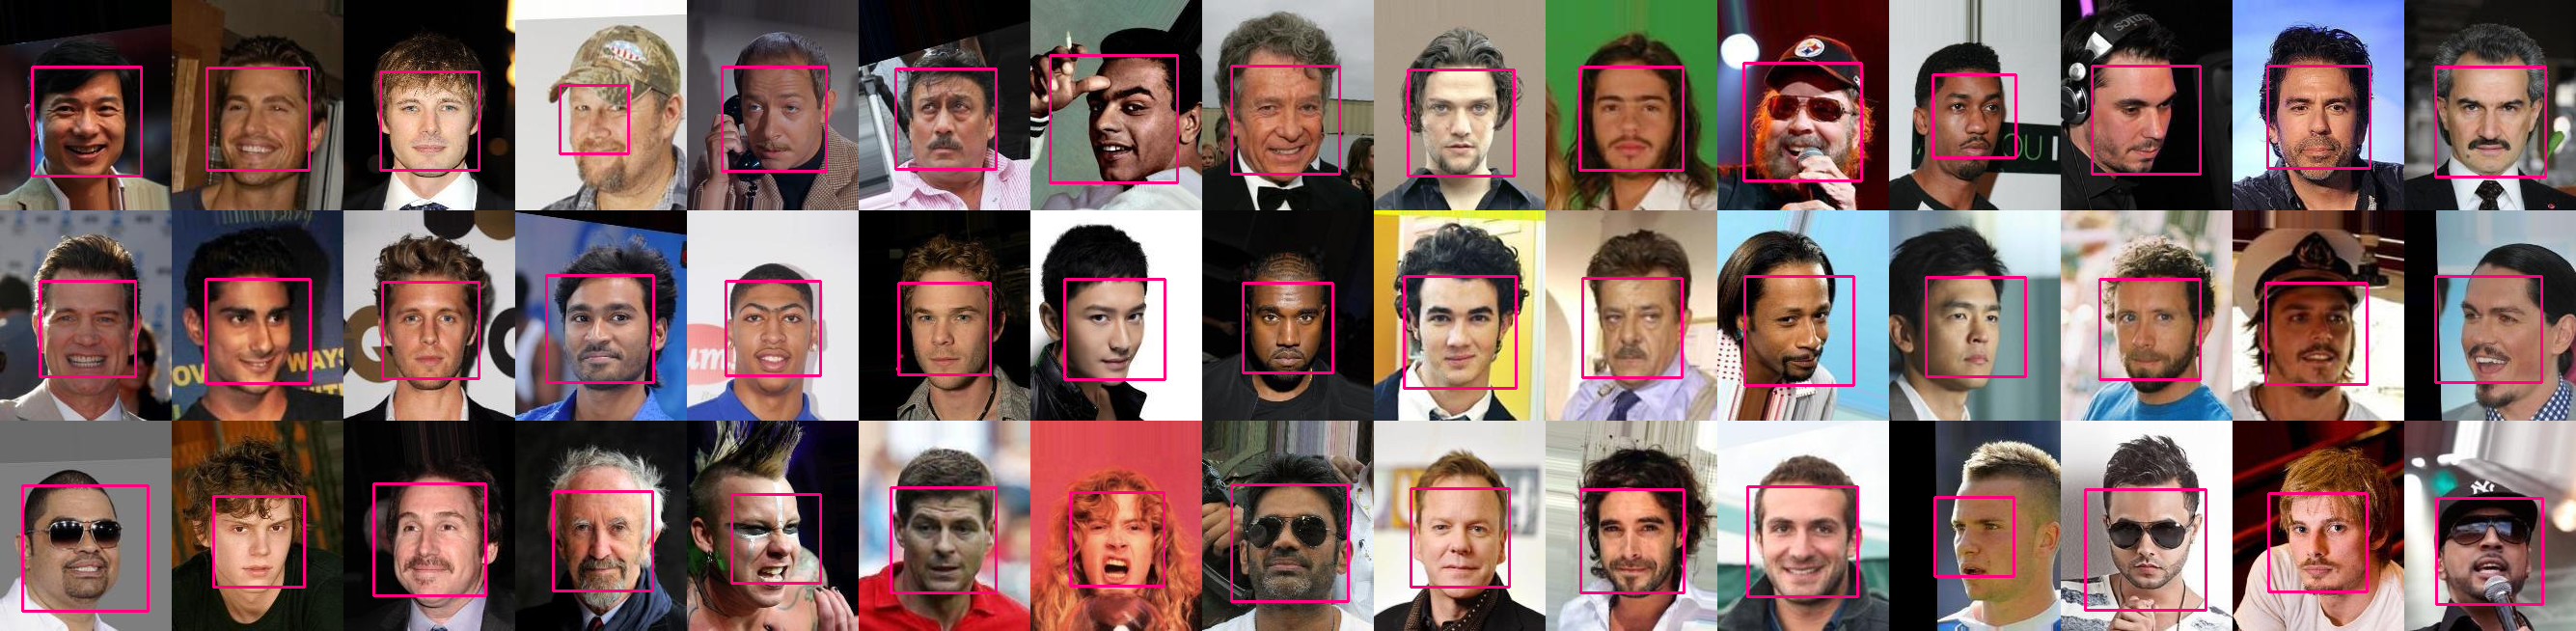

In [29]:
images = np.concatenate((images1, images2), axis=0)
images = np.concatenate((images, images3), axis=0)
cv2_imshow(images)

# **Mustache Detection Without OpenCV** 👨/🧑








In [30]:
mustache_data.replace(to_replace=1,value='Yes',inplace=True)
mustache_data.replace(to_replace=-1,value='No',inplace=True)

In [31]:
mustache_data['image_path'] = mustache_data.apply(lambda row: BASE_PATH + row.name,axis=1)

In [32]:
mustache_data.head()

,Mustache,image_path
image_id,,
005030.jpg,No,/content/train/img_align_celeba/img_align_cele...
081669.jpg,Yes,/content/train/img_align_celeba/img_align_cele...
017429.jpg,No,/content/train/img_align_celeba/img_align_cele...
002990.jpg,No,/content/train/img_align_celeba/img_align_cele...
101705.jpg,Yes,/content/train/img_align_celeba/img_align_cele...


In [33]:
train_data = mustache_data[:8000]
val_data = mustache_data[8000:10000]
test_data = mustache_data[10000:14000]

In [34]:
mustache_data.shape, train_data.shape, val_data.shape,test_data.shape

((16000, 2), (8000, 2), (2000, 2), (4000, 2))

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    rescale=1/255,
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

In [36]:
train_generator = train_datagen.flow_from_dataframe(train_data,x_col='image_path',y_col='Mustache',target_size=(256,256))
val_generator = val_datagen.flow_from_dataframe(val_data,x_col='image_path',y_col='Mustache',target_size=(256,256))

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [37]:
from keras.applications.inception_v3 import InceptionV3

In [38]:
inception = InceptionV3(include_top=False,input_shape=(256,256,3),classes=2)

87916544/87910968 [==============================] - 1s 0us/step


In [39]:
inception.trainable = False

# ***`Trained Models Ahead`*❗**

In [ ]:
# Trial 3
keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
157/157 [==============================] - 831s 5s/step - loss: 0.6695 - accuracy: 0.5954 - val_loss: 0.6161 - val_accuracy: 0.6710
Epoch 2/20
157/157 [==============================] - 827s 5s/step - loss: 0.6194 - accuracy: 0.6626 - val_loss: 0.5606 - val_accuracy: 0.7100
Epoch 3/20
157/157 [==============================] - 828s 5s/step - loss: 0.5941 - accuracy: 0.6890 - val_loss: 0.5474 - val_accuracy: 0.7150
Epoch 4/20
157/157 [==============================] - 827s 5s/step - loss: 0.5820 - accuracy: 0.6890 - val_loss: 0.5894 - val_accuracy: 0.6820
Epoch 5/20
157/157 [==============================] - 826s 5s/step - loss: 0.5833 - accuracy: 0.6954 - val_loss: 0.5384 - val_accuracy: 0.7330
Epoch 6/20
157/157 [==============================] - 826s 5s/step - loss: 0.5756 - accuracy: 0.7020 - val_loss: 0.6276 - val_accuracy: 0.6700
Epoch 7/20
157/157 [==============================] - 827s 5s/step - loss: 0.5643 - accuracy: 0.7016 - val_loss: 0.5313 - val_accuracy: 0.7440

In [ ]:
# Trial 4
keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
157/157 [==============================] - 836s 5s/step - loss: 0.6616 - accuracy: 0.5992 - val_loss: 0.6157 - val_accuracy: 0.6430
Epoch 2/20
157/157 [==============================] - 838s 5s/step - loss: 0.6087 - accuracy: 0.6627 - val_loss: 0.5869 - val_accuracy: 0.6950
Epoch 3/20
157/157 [==============================] - 836s 5s/step - loss: 0.6054 - accuracy: 0.6731 - val_loss: 0.5552 - val_accuracy: 0.7140
Epoch 4/20
157/157 [==============================] - 835s 5s/step - loss: 0.5977 - accuracy: 0.6915 - val_loss: 0.5674 - val_accuracy: 0.7050
Epoch 5/20
157/157 [==============================] - 831s 5s/step - loss: 0.5822 - accuracy: 0.7000 - val_loss: 0.5369 - val_accuracy: 0.7260
Epoch 6/20
157/157 [==============================] - 831s 5s/step - loss: 0.5845 - accuracy: 0.7014 - val_loss: 0.5590 - val_accuracy: 0.7140
Epoch 7/20
157/157 [==============================] - 831s 5s/step - loss: 0.5662 - accuracy: 0.7206 - val_loss: 0.5337 - val_accuracy: 0.7240

In [ ]:
# Trial 5
keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
157/157 [==============================] - 879s 6s/step - loss: 0.6778 - accuracy: 0.5751 - val_loss: 0.5973 - val_accuracy: 0.6750
Epoch 2/20
157/157 [==============================] - 873s 6s/step - loss: 0.6347 - accuracy: 0.6436 - val_loss: 0.5987 - val_accuracy: 0.6680
Epoch 3/20
157/157 [==============================] - 874s 6s/step - loss: 0.6120 - accuracy: 0.6582 - val_loss: 0.5627 - val_accuracy: 0.7080
Epoch 4/20
157/157 [==============================] - 877s 6s/step - loss: 0.6098 - accuracy: 0.6705 - val_loss: 0.5655 - val_accuracy: 0.7120
Epoch 5/20
157/157 [==============================] - 877s 6s/step - loss: 0.6102 - accuracy: 0.6543 - val_loss: 0.5580 - val_accuracy: 0.7090
Epoch 6/20
157/157 [==============================] - 878s 6s/step - loss: 0.5913 - accuracy: 0.6835 - val_loss: 0.5654 - val_accuracy: 0.7130
Epoch 7/20
157/157 [==============================] - 880s 6s/step - loss: 0.5926 - accuracy: 0.6819 - val_loss: 0.5550 - val_accuracy: 0.7080

KeyboardInterrupt: ignored

In [ ]:
# Trial 6
keras.backend.clear_session()

def create_model(layers):
  x = GlobalAveragePooling2D()(inception.output)
  for i,nodes in enumerate(layers):
    print(nodes)
    x = Dense(layers, activation='relu')(x) 

  x = Dense(2,activation='softmax')(x)
  model = Model(inception.inputs,x)
  model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'], loss=binary_crossentropy)
  return model

model = KerasClassifier(build_fn=create_model)

In [ ]:
layers = [[1024,512,256,128],[1024,1024,512,256],[1024,512,512,256],[1024,1024,512,256,128],[1024,512,256,128,64],[1024,512,256,128,128]]

param_grid = dict(layers=layers, epochs=[10])

grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [ ]:
x, y = train_generator.next()
y.shape

(32, 2)

In [ ]:
def toString(z):
  return str(z)

In [ ]:
np.apply_along_axis(toString, 1, y)

array(['[0. 1.]', '[1. 0.]', '[1. 0.]', '[1. 0.]', '[1. 0.]', '[0. 1.]',
       '[0. 1.]', '[0. 1.]', '[1. 0.]', '[0. 1.]', '[1. 0.]', '[0. 1.]',
       '[1. 0.]', '[0. 1.]', '[1. 0.]', '[0. 1.]', '[1. 0.]', '[1. 0.]',
       '[0. 1.]', '[0. 1.]', '[1. 0.]', '[0. 1.]', '[1. 0.]', '[1. 0.]',
       '[1. 0.]', '[0. 1.]', '[0. 1.]', '[1. 0.]', '[1. 0.]', '[1. 0.]',
       '[0. 1.]', '[0. 1.]'], dtype='<U7')

In [ ]:
y.shape

(32, 2)

In [ ]:
grid.fit(x,y)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
inception.summary()

In [ ]:
len(inception.layers)

311

In [ ]:
# Trial 7
train_layer = inception.layers[-17:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
157/157 [==============================] - 916s 6s/step - loss: 0.6660 - accuracy: 0.5871 - val_loss: 0.5669 - val_accuracy: 0.7090
Epoch 2/20
157/157 [==============================] - 914s 6s/step - loss: 0.5878 - accuracy: 0.6840 - val_loss: 0.5188 - val_accuracy: 0.7550
Epoch 3/20
157/157 [==============================] - 911s 6s/step - loss: 0.5396 - accuracy: 0.7347 - val_loss: 0.5217 - val_accuracy: 0.7460
Epoch 4/20
157/157 [==============================] - 908s 6s/step - loss: 0.5252 - accuracy: 0.7439 - val_loss: 0.4908 - val_accuracy: 0.7690
Epoch 5/20
157/157 [==============================] - 904s 6s/step - loss: 0.5072 - accuracy: 0.7582 - val_loss: 0.4918 - val_accuracy: 0.7760
Epoch 6/20
157/157 [==============================] - 908s 6s/step - loss: 0.4761 - accuracy: 0.7775 - val_loss: 0.4916 - val_accuracy: 0.7710
Epoch 7/20
157/157 [==============================] - 907s 6s/step - loss: 0.4917 - accuracy: 0.7566 - val_loss: 0.5171 - val_accuracy: 0.7800

KeyboardInterrupt: ignored

In [ ]:
# Trial 7.1
train_layer = inception.layers[-17:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
250/250 [==============================] - 1497s 6s/step - loss: 0.6330 - accuracy: 0.6385 - val_loss: 0.5624 - val_accuracy: 0.7150
Epoch 2/20
250/250 [==============================] - 1490s 6s/step - loss: 0.5515 - accuracy: 0.7236 - val_loss: 0.5079 - val_accuracy: 0.7585
Epoch 3/20
250/250 [==============================] - 1489s 6s/step - loss: 0.5146 - accuracy: 0.7457 - val_loss: 0.5003 - val_accuracy: 0.7705
Epoch 4/20
250/250 [==============================] - 1488s 6s/step - loss: 0.4944 - accuracy: 0.7591 - val_loss: 0.5004 - val_accuracy: 0.7750
Epoch 5/20
250/250 [==============================] - 1488s 6s/step - loss: 0.4937 - accuracy: 0.7670 - val_loss: 0.4858 - val_accuracy: 0.7805
Epoch 6/20
250/250 [==============================] - 1488s 6s/step - loss: 0.4884 - accuracy: 0.7680 - val_loss: 0.5070 - val_accuracy: 0.7840
Epoch 7/20
250/250 [==============================] - 1485s 6s/step - loss: 0.4936 - accuracy: 0.7687 - val_loss: 0.4873 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# trial 7.2
train_layer = inception.layers[-17:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
250/250 [==============================] - 1512s 6s/step - loss: 0.7795 - accuracy: 0.6458 - val_loss: 0.5139 - val_accuracy: 0.7570
Epoch 2/10
250/250 [==============================] - 1497s 6s/step - loss: 0.5145 - accuracy: 0.7576 - val_loss: 0.5134 - val_accuracy: 0.7590
Epoch 3/10
250/250 [==============================] - 1499s 6s/step - loss: 0.5024 - accuracy: 0.7617 - val_loss: 0.5340 - val_accuracy: 0.7535
Epoch 4/10
250/250 [==============================] - 1498s 6s/step - loss: 0.5034 - accuracy: 0.7621 - val_loss: 0.4916 - val_accuracy: 0.7700
Epoch 5/10
250/250 [==============================] - 1502s 6s/step - loss: 0.4859 - accuracy: 0.7690 - val_loss: 0.4927 - val_accuracy: 0.7790
Epoch 6/10
250/250 [==============================] - 1506s 6s/step - loss: 0.4768 - accuracy: 0.7800 - val_loss: 0.4948 - val_accuracy: 0.7785
Epoch 7/10
 43/250 [====>.........................] - ETA: 16:55 - loss: 0.4452 - accuracy: 0.7899

KeyboardInterrupt: ignored

In [ ]:
# trial 8
keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
250/250 [==============================] - 1299s 5s/step - loss: 0.8298 - accuracy: 0.5757 - val_loss: 0.8127 - val_accuracy: 0.5240
Epoch 2/10
250/250 [==============================] - 1295s 5s/step - loss: 0.6432 - accuracy: 0.6412 - val_loss: 0.5771 - val_accuracy: 0.7075
Epoch 3/10
250/250 [==============================] - 1296s 5s/step - loss: 0.6161 - accuracy: 0.6675 - val_loss: 0.5830 - val_accuracy: 0.6960
Epoch 4/10
250/250 [==============================] - 1295s 5s/step - loss: 0.5996 - accuracy: 0.6866 - val_loss: 0.5782 - val_accuracy: 0.7165
Epoch 5/10
250/250 [==============================] - 1293s 5s/step - loss: 0.5873 - accuracy: 0.7003 - val_loss: 0.5660 - val_accuracy: 0.7240
Epoch 6/10
250/250 [==============================] - 1293s 5s/step - loss: 0.5799 - accuracy: 0.7109 - val_loss: 0.5461 - val_accuracy: 0.7265
Epoch 7/10
250/250 [==============================] - 1296s 5s/step - loss: 0.5911 - accuracy: 0.6939 - val_loss: 0.5585 - val_accuracy:

In [ ]:
# trial 8.1
keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
250/250 [==============================] - 1377s 5s/step - loss: 0.9588 - accuracy: 0.5417 - val_loss: 0.9222 - val_accuracy: 0.6445
Epoch 2/10
250/250 [==============================] - 1412s 6s/step - loss: 0.6460 - accuracy: 0.6610 - val_loss: 0.5928 - val_accuracy: 0.6980
Epoch 3/10
250/250 [==============================] - 1393s 6s/step - loss: 0.6210 - accuracy: 0.6689 - val_loss: 0.5918 - val_accuracy: 0.6925
Epoch 4/10
250/250 [==============================] - 1355s 5s/step - loss: 0.6013 - accuracy: 0.6830 - val_loss: 0.5781 - val_accuracy: 0.7105
Epoch 5/10
250/250 [==============================] - 1358s 5s/step - loss: 0.5918 - accuracy: 0.6994 - val_loss: 0.5625 - val_accuracy: 0.7100
Epoch 6/10
250/250 [==============================] - 1407s 6s/step - loss: 0.5879 - accuracy: 0.6958 - val_loss: 0.5939 - val_accuracy: 0.7095
Epoch 7/10
250/250 [==============================] - 1388s 6s/step - loss: 0.5811 - accuracy: 0.7040 - val_loss: 0.5567 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# trial 8.2
train_layer = inception.layers[-17:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
250/250 [==============================] - 1466s 6s/step - loss: 0.8355 - accuracy: 0.5944 - val_loss: 0.5720 - val_accuracy: 0.7640
Epoch 2/10
250/250 [==============================] - 1421s 6s/step - loss: 0.5306 - accuracy: 0.7561 - val_loss: 0.4836 - val_accuracy: 0.7785
Epoch 3/10
250/250 [==============================] - 1457s 6s/step - loss: 0.5275 - accuracy: 0.7491 - val_loss: 0.4892 - val_accuracy: 0.7945
Epoch 4/10
250/250 [==============================] - 1443s 6s/step - loss: 0.4891 - accuracy: 0.7704 - val_loss: 0.4931 - val_accuracy: 0.7575
Epoch 5/10
250/250 [==============================] - 1416s 6s/step - loss: 0.4938 - accuracy: 0.7653 - val_loss: 0.4859 - val_accuracy: 0.7790
Epoch 6/10
250/250 [==============================] - 1413s 6s/step - loss: 0.4830 - accuracy: 0.7714 - val_loss: 0.4843 - val_accuracy: 0.7905
Epoch 7/10
250/250 [==============================] - 1453s 6s/step - loss: 0.4807 - accuracy: 0.7741 - val_loss: 0.5267 - val_accuracy:

In [ ]:
# trial 8.3
train_layer = inception.layers[-17:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
250/250 [==============================] - 1465s 6s/step - loss: 0.6755 - accuracy: 0.7109 - val_loss: 0.4723 - val_accuracy: 0.7835
Epoch 2/10
250/250 [==============================] - 1457s 6s/step - loss: 0.4948 - accuracy: 0.7758 - val_loss: 0.4663 - val_accuracy: 0.7875
Epoch 3/10
250/250 [==============================] - 1501s 6s/step - loss: 0.4711 - accuracy: 0.7851 - val_loss: 0.4696 - val_accuracy: 0.7955
Epoch 4/10
250/250 [==============================] - 1457s 6s/step - loss: 0.4702 - accuracy: 0.7809 - val_loss: 0.5169 - val_accuracy: 0.7795
Epoch 5/10
250/250 [==============================] - 1502s 6s/step - loss: 0.4551 - accuracy: 0.7925 - val_loss: 0.4805 - val_accuracy: 0.7750
Epoch 6/10
250/250 [==============================] - 1483s 6s/step - loss: 0.4511 - accuracy: 0.7902 - val_loss: 0.4541 - val_accuracy: 0.7985
Epoch 7/10
250/250 [==============================] - 1459s 6s/step - loss: 0.4599 - accuracy: 0.7875 - val_loss: 0.4551 - val_accuracy:

In [ ]:
# Trial 9
train_layer = inception.layers[52:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
250/250 [==============================] - 3714s 15s/step - loss: 0.5153 - accuracy: 0.7354 - val_loss: 0.9591 - val_accuracy: 0.8530
Epoch 2/20
250/250 [==============================] - 3709s 15s/step - loss: 0.3413 - accuracy: 0.8575 - val_loss: 0.9153 - val_accuracy: 0.8455
Epoch 3/20
250/250 [==============================] - 3711s 15s/step - loss: 0.3243 - accuracy: 0.8729 - val_loss: 1.7898 - val_accuracy: 0.8535
Epoch 4/20
250/250 [==============================] - 3706s 15s/step - loss: 0.2847 - accuracy: 0.8793 - val_loss: 0.4725 - val_accuracy: 0.8810
Epoch 5/20
250/250 [==============================] - 3733s 15s/step - loss: 0.2738 - accuracy: 0.8867 - val_loss: 0.7740 - val_accuracy: 0.8790
Epoch 6/20
250/250 [==============================] - 3738s 15s/step - loss: 0.2660 - accuracy: 0.8900 - val_loss: 0.6537 - val_accuracy: 0.8720
Epoch 7/20
250/250 [==============================] - 3747s 15s/step - loss: 0.2451 - accuracy: 0.8991 - val_loss: 1.4685 - val_ac

In [ ]:
# Trial 10
train_layer = inception.layers[52:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
250/250 [==============================] - 3121s 12s/step - loss: 0.6255 - accuracy: 0.6759 - val_loss: 7.7203 - val_accuracy: 0.5130
Epoch 2/10
250/250 [==============================] - 3111s 12s/step - loss: 0.3883 - accuracy: 0.8384 - val_loss: 0.7124 - val_accuracy: 0.7930
Epoch 3/10
250/250 [==============================] - 3104s 12s/step - loss: 0.3477 - accuracy: 0.8538 - val_loss: 0.3442 - val_accuracy: 0.8455
Epoch 4/10
250/250 [==============================] - 3105s 12s/step - loss: 0.3262 - accuracy: 0.8655 - val_loss: 1.9685 - val_accuracy: 0.7810
Epoch 5/10
250/250 [==============================] - 3124s 12s/step - loss: 0.3164 - accuracy: 0.8644 - val_loss: 0.3947 - val_accuracy: 0.8670
Epoch 6/10
250/250 [==============================] - 3106s 12s/step - loss: 0.3056 - accuracy: 0.8688 - val_loss: 0.4000 - val_accuracy: 0.8610
Epoch 7/10
250/250 [==============================] - 3122s 12s/step - loss: 0.2924 - accuracy: 0.8800 - val_loss: 0.5951 - val_ac

# ***Current Best Model***

In [42]:
# Trial 10.1
train_layer = inception.layers[52:]
for i in train_layer:
  i.trainable = True

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator,epochs=15,validation_data=val_generator)

Epoch 1/15
250/250 [==============================] - 149s 560ms/step - loss: 0.6900 - accuracy: 0.5710 - val_loss: 1.1854 - val_accuracy: 0.7560
Epoch 2/15
250/250 [==============================] - 138s 550ms/step - loss: 0.4316 - accuracy: 0.8196 - val_loss: 0.8128 - val_accuracy: 0.7260
Epoch 3/15
250/250 [==============================] - 137s 550ms/step - loss: 0.3696 - accuracy: 0.8431 - val_loss: 0.4345 - val_accuracy: 0.8510
Epoch 4/15
250/250 [==============================] - 137s 547ms/step - loss: 0.3492 - accuracy: 0.8517 - val_loss: 0.6582 - val_accuracy: 0.8135
Epoch 5/15
250/250 [==============================] - 134s 536ms/step - loss: 0.3438 - accuracy: 0.8587 - val_loss: 0.3516 - val_accuracy: 0.8655
Epoch 6/15
250/250 [==============================] - 133s 532ms/step - loss: 0.3389 - accuracy: 0.8599 - val_loss: 0.3903 - val_accuracy: 0.8425
Epoch 7/15
250/250 [==============================] - 133s 532ms/step - loss: 0.3110 - accuracy: 0.8690 - val_loss: 1.1876 -

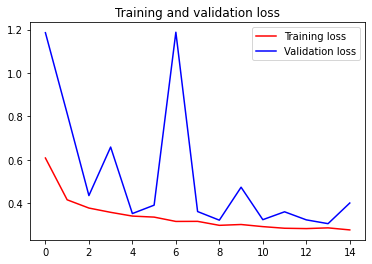

<Figure size 432x288 with 0 Axes>

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

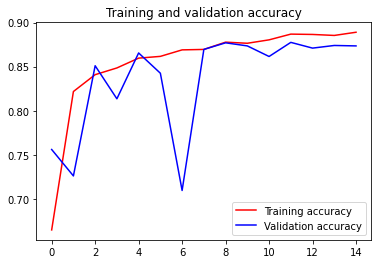

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [45]:
model.save_weights('mustache_detection_inception_wo_opencv.h5')

In [46]:
files.download('mustache_detection_inception_wo_opencv.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Load Model** 

In [40]:
keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

In [41]:
# upload model weights
files.upload()

Saving mustache_detection_inception_wo_opencv.h5 to mustache_detection_inception_wo_opencv.h5


In [ ]:
model.load_weights('/content/mustache_detection_inception_wo_opencv.h5')

# **Model Prediction**

In [ ]:
classes = ['No Mustache Detected','Mustache Detected']

In [ ]:
# Sample Image Prediction

def predict_mustache(imagePath):
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faces = face_classifier.detectMultiScale(gray, 1.05, 5)

  # Condition: Works only when 1 face is detected
  if len(faces) == 1:
    for (x,y,w,h) in faces:
      cropped_img = image[y:y+h,x:x+w]
      cropped_img = cv2.resize(cropped_img, (256, 256)) 
      img_tensor = img_to_array(img)
      img_tensor = np.expand_dims(img_tensor, axis=0)
      img_tensor /= 255.
      prediction = model.predict(img_tensor)
      prediction_class = classes[np.argmax(prediction)]
      cv2_imshow(image)
      print(prediction_class)

In [ ]:
from random import randint
from keras.preprocessing.image import load_img,img_to_array

Expected: Yes


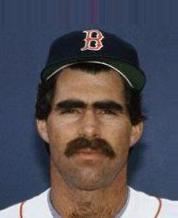

Mustache Detected


In [48]:
idx = randint(1,test_data.shape[0])
imageName = test_data.index[idx]
actual = test_data.loc[imageName]['Mustache']
print('Expected: {}'.format(actual))
imagePath = BASE_PATH + imageName
predict_mustache(imagePath)

# **Model Analysis**

**Trial 1** 🔴

Use InceptionV3 with GlobalAveragePooling, Softmax layers

> Result: The model was slow in learning 

---
**Trial 2** 🔴

*Trail 1* + 1024 neurons relu layer

> Result: The model did not learn. No visible increase in accuracy 

---
**Trail 3** 🔴

*Trail 2* + 512 neurons relu layer

> Result: Very slow learning. The model might need more epochs, but limited by Computational power. Doubtful that model might overfit.

*Additional Trials*

- Try 20 epochs - check if accuracy crosses 80% 
> Result: Slow learning with too many fluctuations in accuracy. Reached 76% accuracy on 20 epochs.
  
---
**Trial 4** 🔴

*Trail 3* + 256 Relu Layer

> Expectation: Model might learn more

> Result: Better performance than Trail 3 till 10 epochs. But overfits on 20 epochs. Lesser noise seen on validation accuracy

---
**Trial 5** 🔴

*Trail 4* + 0.3 Dropout

> Expectation: Reduce overfitting

> Result: Model does not learn.

---
**Trial 6** 🔴

Use a paramgrid

> Expectation: Costs more time and computational power.

> Result: Didn't work

---
**Trial 7** 🟡

Train last 17 of Inception model + *Trial 4*

> Result: Better Performance. 79% validation accuracy on 8 epochs after which it overfits. Accuracy staggers

*Additional Trials*

- Increase dataset from 5000-1000 to 8000-2000 images
> Result: Learning is slow. Overfits

- Increase learning rate from 0.0001 to 0.001
> Result: Staggered learning after few epochs

> **Inference: Training on last 17 layers works!**

---
**Trial 8** 🔴

*Trail 4* + 1024 units Relu layer with 0.001 lr and 8000-2000 images

> Result : **Better learning**. Learning retarding after 6 epochs.   

*Additional Trials*

- *Trail 8* + 1024 units Relu layer
> Result: Not too much overfitting. Can try on 20 epochs.

- *Trail 8.1* trained on last 17 layers of inception model.
> Result: **Better Learning**. Too much fluctuations in validation.

- *Trail 8.2* - 1024 units Relu layer
> Result: Overfits. Learning is slower

---
**Trial 9** 🟡

*Trial 4* + training last 52 layers of inception 

> Result: **Better Learning**. Too many fluctuations on validation.

---
**Trial 10** 🟢

*Trial 1* + training last 52 layers of inception

> Result: **Best Learning**. Overfits after 7 epochs with **87.4%** validation accuracy.

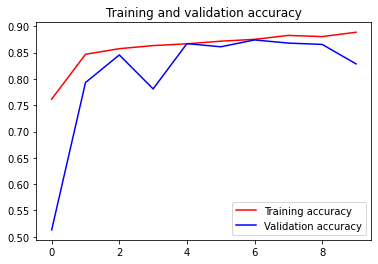

*Additional Trials*

- *Trial 10* + 1024 relu layer
> Result: Learning is slow after 3 epochs. Reached an accuracy of **88.4%** on validation

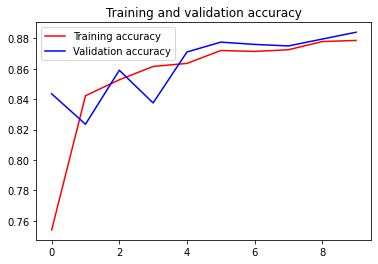

---
**Trial A** 

Convert the images to grey. 

> Expectation: Might reduce computational time & power, coz lower dimension

---
**Trial B**

Use ResNet/ VGG16/ VGG19 

> Expectation: Might reduce computational time & power, coz reduced no of layers

---
## *Additional Ideas*

- Use Sigmoid output layer - Doesn't work
- Train the last few layers of Inception model - Worked🎉

## Annotation 

🟢 - Currently working best

🟡 - Works but contains flaws

🔴 - Doesn't work to the expected level